# 感想戦
## 反省
- local cvとpublic LBとのズレと、「信頼できるLocal CV」の作り方をちゃんとしなかったのはよくなかった。
- ここをそこそこやるだけでもよさそうだよねという一方、postprocessingというのをよく知らなかった
- 信頼できるCV作る前に「上を当てりゃあどうにかなるやろ」と思っていたのはダメでした。

## giba's solution
- ikiri_DSでもpostprocessingをしてたgibaのSolution
- postprocessingはあまりしたことがなかったのでこのkernelではこれを勉強します
    - [Solutionはここ](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/94466#latest-544776)
- 平均をどう出したのかはよくわからないけどとりあえず「わかったことにして」当てはめてみる
    - 特徴量群は違うとは思うけどとりあえずありもので何とかする。
- ハイパーパラメータの設定まで再現できる。きぬいとの特徴量でどれだけ上がるかを見ることもできそう。
    - 寄せないデータでどれだけインパクトするかがわかると、直前にする悪あがきなのか、戦略としてあらかじめ頭に入れておくべきなのかもわかる

## 1st solution
- 別Kernelで特徴量から作り直す必要があるので別kernelで特徴量を作るところから検討します……

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import lightgbm as lgb

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['kur0cky-data-output', 'output-my-datatable', 'LANL-Earthquake-Prediction', 'output-my-datatable2-autocorr-generation']


In [2]:
y_type = pd.read_csv('../input/kur0cky-data-output/kur0cky_train_for_quantile.csv')['y_type']

## Kien data

In [3]:
Kien_train   = pd.read_csv('../input/output-my-datatable2-autocorr-generation/Kien_train_data_3.csv')
Kien_test    = pd.read_csv('../input/output-my-datatable2-autocorr-generation/Kien_test_data_3.csv')
y_train = Kien_train['time_to_failure']
Kien_train.drop('time_to_failure', axis = 1, inplace = True)
Kien_train['abs_skew'] = np.abs(Kien_train['skew'])
Kien_test['abs_skew'] = np.abs(Kien_test['skew'])



In [4]:
scaler = StandardScaler()
scaler.fit(Kien_train)
Kien_train_scaled = pd.DataFrame(scaler.transform(Kien_train), columns = Kien_train.columns)
Kien_test_scaled  = pd.DataFrame(scaler.transform(Kien_test) , columns = Kien_test.columns)
print(Kien_train_scaled.describe())
print(Kien_test_scaled.describe())
use_col = Kien_train_scaled.columns.values
# kur0ckyデータのStratifyを反映。
Kien_train_scaled['y_type'] = y_type

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:776: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:781: RuntimeWarning: Degrees of freedom <= 0 for slice.
  new_unnormalized_variance = np.nanvar(X, axis=0) * new_sample_count
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64

               mean      ...           abs_skew
count  4.194000e+03      ...       4.194000e+03
mean   3.401761e-15      ...       1.784192e-17
std    1.000119e+00      ...       1.000119e+00
min   -3.605375e+00      ...      -7.202581e-01
25%   -6.638557e-01      ...      -5.503660e-01
50%    9.851234e-03      ...      -3.200234e-01
75%    6.791319e-01      ...       1.222005e-01
max    3.407671e+00      ...       9.802238e+00

[8 rows x 253 columns]
              mean          min     ...       max_autolag_1_order     abs_skew
count  2624.000000  2624.000000     ...                       0.0  2624.000000
mean     -1.448353    -0.018414     ...                       NaN    -0.026057
std       0.985462     1.099192     ...                       NaN     0.898564
min      -4.332867   -23.290089     ...                       NaN    -0.720247
25%      -2.129834    -0.048217     ...                       NaN    -0.548963
50%      -1.450588     0.121542     ...                       NaN    -

## Stratifiedについて
- 露骨に「ピークとそれ以外」で交差検証したら、どうなっちゃうのかなあ

In [5]:
#Kien_train_scaled['y_type'] = y_train.round()

In [6]:
Kien_train_scaled.describe()

,mean,min,max,std,median,var,skew,abs_max,abs_mean,abs_std,iqr,ave10,ave20,ave30,ave40,ave50,trend,abs_trend,shift_4096_mean,shift_4096_std,shift_4096_min,shift_4096_max,shift_8192_mean,shift_8192_std,shift_8192_min,shift_8192_max,quantile_999,quantile_001,quantile_99,quantile_01,quantile_95,quantile_90,quantile_85,quantile_80,quantile_75,quantile_70,quantile_65,quantile_60,quantile_55,quantile_50,...,max_roll_mean_100,min_roll_mean_100,q01_roll_mean_100,q05_roll_mean_100,q95_roll_mean_100,q99_roll_mean_100,av_change_abs_roll_mean_100,av_change_rate_roll_mean_100,abs_max_roll_mean_100,ave_roll_std_1000,std_roll_std_1000,max_roll_std_1000,min_roll_std_1000,q01_roll_std_1000,q05_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,av_change_abs_roll_std_1000,av_change_rate_roll_std_1000,abs_max_roll_std_1000,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,av_change_rate_roll_mean_1000,abs_max_roll_mean_1000,max_count,Hilbert_count_max,Hilbert_order_max,std_count,Hilbert_count_std,Hilbert_order_std,max_autolag_1_count,max_autolag_1_order,abs_skew
count,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,0.0,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,...,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.194000e+03,4.280000e+02,4.194000e+03,4.194000e+03,5.400000e+01,4.194000e+03,4.280000e+02,4.194000e+03
mean,3.401761e-15,1.495651e-17,-4.036934e-17,-6.390268e-17,3.872915e-15,2.253403e-18,-6.972645e-17,5.122274e-17,3.103012e-16,-1.649187e-17,3.270843e-16,-9.493917e-16,2.946789e-15,-2.634634e-15,6.610761e-16,NaN,1.318291e-17,3.808037e-17,2.924378e-17,2.040968e-17,-9.794528e-19,4.854909e-17,-6.426782e-16,1.125577e-16,1.287848e-17,-2.726585e-17,8.735660e-19,-5.244043e-17,-5.818479e-17,6.152023e-17,6.898789e-16,-1.352810e-15,1.727755e-15,-8.618338e-15,2.500199e-15,2.484792e-15,2.610109e-15,5.895353e-15,-1.096078e-14,3.872915e-15,...,2.078028e-17,8.338585e-18,1.397970e-16,8.828576e-16,1.483659e-15,2.866355e-16,-3.083953e-17,1.216036e-14,8.603302e-18,5.440728e-16,-1.293142e-17,9.701877e-18,-2.421419e-15,-6.713223e-16,1.495598e-15,-2.173062e-16,-4.476364e-17,-6.882642e-19,-9.901834e-14,9.701877e-18,-3.422310e-15,-9.537091e-17,-1.993782e-16,-2.077367e-17,1.450014e-15,-1.583868e-16,3.412202e-17,8.967685e-16,9.728349e-18,4.799065e-14,-1.993782e-16,-4.036934e-17,-2.951065e-16,-2.356371e-15,-6.582188e-17,-2.580991e-16,-6.167906e-17,-2.951065e-16,-2.356371e-15,1.784192e-17
std,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,NaN,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,...,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000119e+00,1.000

# Feature Engineering
- 露骨に跳ねるパターン(Jumper)
- じわじわ上がるパターン(Stressor)
- じわじわ下がるパターン(Destressor)
- 上記全部(selected_features)
- それ以外も全部(Full)

In [7]:
selected_features = ['abs_mean', 'max', 'std', 'abs_std', 'Hilbert_Trns_abs_mean', 'Hilbert_Trns_max', 'Hilbert_Trns_var', 
                     'Hann_window_max_100', 'Hann_window_max_150', 'Hann_window_max_200', 'Hann_window_var_100', 'Hann_window_var_150',
                     'Hann_window_var_200', 'quantile_999', 'std_roll_mean_10', 'std_roll_mean_100', 'std_roll_mean_1000', 'std_roll_std_10',
                     'std_roll_std_100', 'std_roll_std_1000', 'q95_roll_std_10', 'q99_roll_std_10', 'q95_roll_mean_10', 'q99_roll_mean_10', 
                     'q95_roll_std_10', 'q99_roll_std_10', 'q95_roll_mean_10', 'q99_roll_mean_100', 'abs_max_roll_mean_10', 'abs_max_roll_mean_100',
                     'abs_max_roll_mean_1000', 'abs_autocorr_lag1', 'abs_autocorr_lag2', 'abs_autocorr_lag3', 'abs_autocorr_lag4', 'abs_autocorr_lag5',
                     'abs_autocorr_lag6', 'abs_autocorr_lag7', 'abs_autocorr_lag8', 'abs_autocorr_lag9', 'abs_autocorr_lag10', 'abs_autocorr_lag11',
                     'abs_autocorr_lag12', 'abs_autocorr_lag13', 'abs_autocorr_lag14', 'abs_autocorr_lag15', 'abs_autocorr_lag16', 'abs_autocorr_lag17',
                     'abs_autocorr_lag18', 'abs_autocorr_lag19', 'abs_autocorr_lag20', 'abs_autocorr_lag21', 'abs_autocorr_lag22', 'abs_autocorr_lag23',
                     'abs_autocorr_lag24', 'abs_autocorr_lag25', 'abs_autocorr_lag26', 'abs_autocorr_lag27', 'abs_autocorr_lag28', 'abs_autocorr_lag29',
                     'abs_autocorr_lag30', 'abs_autocorr_lag31', 'abs_autocorr_lag32', 'abs_autocorr_lag33', 'abs_autocorr_lag34', 'abs_autocorr_lag35', 
                     'abs_autocorr_lag36', 'abs_autocorr_lag37', 'abs_autocorr_lag38', 'abs_autocorr_lag39', 'abs_autocorr_lag40', 'abs_autocorr_lag41', 
                     'abs_autocorr_lag42', 'abs_autocorr_lag43', 'abs_autocorr_lag44', 'abs_autocorr_lag45', 'abs_autocorr_lag46', 'abs_autocorr_lag47', 
                     'abs_autocorr_lag48', 'abs_autocorr_lag49', 'abs_autocorr_lag50', 'autocorr_lag1', 'autocorr_lag2', 'autocorr_lag3', 'autocorr_lag4',
                     'classic_sta_lta1_mean', 'autocorr_lag6', 'autocorr_lag7', 'autocorr_lag8', 'autocorr_lag9', 'autocorr_lag10', 'abs_skew', 'Hilbert_count_max',
                     'Hilbert_count_std']
Jumper = ['abs_mean','max','std','abs_std','Hilbert_Trns_abs_mean','Hilbert_Trns_max','Hilbert_Trns_var',
          'Hann_window_max_100','Hann_window_max_150','Hann_window_max_200',
          'Hann_window_var_100','Hann_window_var_150','Hann_window_var_200',
          'quantile_999',
         'std_roll_mean_10','std_roll_mean_100','std_roll_mean_1000',
         'std_roll_std_10','std_roll_std_100','std_roll_std_1000',
          'q95_roll_std_10','q99_roll_std_10','q95_roll_mean_10','q99_roll_mean_10',
          'q95_roll_std_10','q99_roll_std_10','q95_roll_mean_10','q99_roll_mean_100',
          'abs_max_roll_mean_10','abs_max_roll_mean_100','abs_max_roll_mean_1000']
Stressor   = ['abs_autocorr_lag1', 'abs_autocorr_lag2', 'abs_autocorr_lag3', 'abs_autocorr_lag4', 'abs_autocorr_lag5', 'abs_autocorr_lag6', 'abs_autocorr_lag7', 
              'abs_autocorr_lag8', 'abs_autocorr_lag9', 'abs_autocorr_lag10', 'abs_autocorr_lag11', 'abs_autocorr_lag12', 'abs_autocorr_lag13', 'abs_autocorr_lag14', 
              'abs_autocorr_lag15', 'abs_autocorr_lag16', 'abs_autocorr_lag17', 'abs_autocorr_lag18', 'abs_autocorr_lag19', 'abs_autocorr_lag20', 'abs_autocorr_lag21', 
              'abs_autocorr_lag22', 'abs_autocorr_lag23', 'abs_autocorr_lag24', 'abs_autocorr_lag25', 'abs_autocorr_lag26', 'abs_autocorr_lag27', 'abs_autocorr_lag28', 
              'abs_autocorr_lag29', 'abs_autocorr_lag30', 'abs_autocorr_lag31', 'abs_autocorr_lag32', 'abs_autocorr_lag33', 'abs_autocorr_lag34', 'abs_autocorr_lag35', 
              'abs_autocorr_lag36', 'abs_autocorr_lag37', 'abs_autocorr_lag38', 'abs_autocorr_lag39', 'abs_autocorr_lag40', 'abs_autocorr_lag41', 'abs_autocorr_lag42', 
              'abs_autocorr_lag43', 'abs_autocorr_lag44', 'abs_autocorr_lag45', 'abs_autocorr_lag46', 'abs_autocorr_lag47', 'abs_autocorr_lag48', 'abs_autocorr_lag49', 
              'abs_autocorr_lag50', 'autocorr_lag1', 'autocorr_lag2', 'autocorr_lag3', 'autocorr_lag4', 'classic_sta_lta1_mean']
Destressor = ['autocorr_lag6','autocorr_lag7','autocorr_lag8','autocorr_lag9','autocorr_lag10','abs_skew','Hilbert_count_max','Hilbert_count_std']

In [8]:
import gc
gc.collect()

137

# fold
- CPMPも16Foldでやってたっぽい。しかも普通のKFoldでよかったんじゃね疑惑
- でもまずはfoldを変えた結果とか、Stratifiedの違いとかの影響を統一して、単純なpostprocessingの効果を検討。

In [9]:
n_fold    = 10#16
folds     = StratifiedKFold(n_splits = n_fold, shuffle = True, random_state = 42)

## LightGBMRegressor
- 関数にしてかっこよく回すことにする

In [10]:
def LGBMReg(train, test, y, n_fold, cat , usecol, method = 'quantile'):
    #oof_table  = pd.DataFrame()
    #pred_table = pd.DataFrame()
    #for quant in [0.1,0.3,0.5,0.7,0.9]:
        #print(str(quant)+' start')
    params = {'num_leaves': 7,
         #'alpha': quant,
         'min_data_in_leaf': 4, 
         'objective': method,
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.025,
         "bagging_freq": 1,
         "bagging_fraction": 0.25,
         "bagging_seed": 42,
         "metric": 'mae',
         "lambda_l1": 1.1,
         "lambda_l2": 0.1,
         "max_bin" : 25,
         "min_data_in_bin":2,
         #"verbosity": -1,
         #"nthread": -1,
         "random_state": 42}
    #run model
    oof                   = np.zeros(len(train))
    train_pred            = np.zeros(len(train))
    predictions           = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()
    X_train_LGB = train[usecol]

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[usecol],train[cat])): # use_colで特徴量を指定し、y_type別に同じ割合だけsampleするようにStratifiedしてます。
        strLog = "fold {}".format(fold_)
        print(strLog)

        X_tr, X_val = X_train_LGB.iloc[trn_idx], X_train_LGB.iloc[val_idx]
        y_tr, y_val = y.iloc[trn_idx]       , y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
        model.fit(X_tr, 
                  y_tr, 
                  eval_set = [(X_tr, y_tr), (X_val, y_val)], 
                  eval_metric = 'mae',
                  verbose = 1000, 
                  early_stopping_rounds = 500)
        oof[val_idx] = model.predict(X_val, num_iteration = model.best_iteration_)

        fold_importance_df               = pd.DataFrame()
        fold_importance_df["Feature"]    = usecol
        fold_importance_df["importance"] = model.feature_importances_[:len(usecol)]
        fold_importance_df["fold"]       = fold_ + 1
        feature_importance_df            = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        predictions += model.predict(test[usecol] , num_iteration=model.best_iteration_) / folds.n_splits
        train_pred  += model.predict(train[usecol], num_iteration = model.best_iteration_)/folds.n_splits

        #oof_table['quantile'+str(quant)]    = oof
        #pred_table['quantile' + str(quant)] = predictions
        #print("quantile: "+str(quant) + " end.")
    #oof_table['time_to_failure'] = y
    return oof, predictions, feature_importance_df

# モデル回し
- methodもgammaにせず、huberでやってみよう。

In [11]:
Kien_quant_J  = LGBMReg(Kien_train_scaled,
                      Kien_test_scaled, y_train, n_fold, cat = 'y_type',method = 'gamma', usecol = Jumper)


fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.19267	valid_1's l1: 2.23653
[2000]	training's l1: 2.1266	valid_1's l1: 2.22356
[3000]	training's l1: 2.08914	valid_1's l1: 2.22182
Early stopping, best iteration is:
[2903]	training's l1: 2.09145	valid_1's l1: 2.22025
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.18553	valid_1's l1: 2.33364
[2000]	training's l1: 2.1173	valid_1's l1: 2.31131
[3000]	training's l1: 2.0789	valid_1's l1: 2.30154
Early stopping, best iteration is:
[2577]	training's l1: 2.0914	valid_1's l1: 2.2981
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.20169	valid_1's l1: 2.20191
[2000]	training's l1: 2.13555	valid_1's l1: 2.15425
[3000]	training's l1: 2.0996	valid_1's l1: 2.13065
[4000]	training's l1: 2.07411	valid_1's l1: 2.12838
[5000]	training's l1: 2.05578	valid_1's l1: 2.1232
Early stopping, best iteration is:
[4936]	training'

In [12]:
Kien_quant_S  = LGBMReg(Kien_train_scaled,
                      Kien_test_scaled, y_train, n_fold, cat = 'y_type',method = 'gamma', usecol = Stressor)


fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.47082	valid_1's l1: 2.49083
[2000]	training's l1: 2.38994	valid_1's l1: 2.45326
[3000]	training's l1: 2.32249	valid_1's l1: 2.41678
[4000]	training's l1: 2.27291	valid_1's l1: 2.39178
[5000]	training's l1: 2.23116	valid_1's l1: 2.37236
[6000]	training's l1: 2.19552	valid_1's l1: 2.35854
[7000]	training's l1: 2.1674	valid_1's l1: 2.34663
Early stopping, best iteration is:
[7262]	training's l1: 2.15922	valid_1's l1: 2.34137
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.46943	valid_1's l1: 2.56158
[2000]	training's l1: 2.38661	valid_1's l1: 2.5038
[3000]	training's l1: 2.31894	valid_1's l1: 2.46366
[4000]	training's l1: 2.26833	valid_1's l1: 2.43505
[5000]	training's l1: 2.22578	valid_1's l1: 2.40955
[6000]	training's l1: 2.19133	valid_1's l1: 2.39657
Early stopping, best iteration is:
[5654]	training's l1: 2.20201	valid_1's l1: 2.39404
fold 2
Train

In [13]:
Kien_quant_D  = LGBMReg(Kien_train_scaled,
                      Kien_test_scaled, y_train, n_fold, cat = 'y_type',method = 'gamma', usecol = Destressor)

fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.38677	valid_1's l1: 2.46792
[2000]	training's l1: 2.3365	valid_1's l1: 2.41627
[3000]	training's l1: 2.31441	valid_1's l1: 2.40658
[4000]	training's l1: 2.30165	valid_1's l1: 2.40252
Early stopping, best iteration is:
[4093]	training's l1: 2.30065	valid_1's l1: 2.40007
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.37833	valid_1's l1: 2.50504
[2000]	training's l1: 2.32404	valid_1's l1: 2.48019
Early stopping, best iteration is:
[2088]	training's l1: 2.3211	valid_1's l1: 2.47849
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.38314	valid_1's l1: 2.47874
[2000]	training's l1: 2.33277	valid_1's l1: 2.4391
[3000]	training's l1: 2.31407	valid_1's l1: 2.42157
[4000]	training's l1: 2.30393	valid_1's l1: 2.40657
[5000]	training's l1: 2.29812	valid_1's l1: 2.39685
[6000]	training's l1: 2.2924	valid_1's l1: 2.38

In [14]:
Kien_quant_A  = LGBMReg(Kien_train_scaled,
                      Kien_test_scaled, y_train, n_fold, cat = 'y_type',method = 'gamma', usecol = selected_features)


fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.0788	valid_1's l1: 2.18033
Early stopping, best iteration is:
[1336]	training's l1: 2.04235	valid_1's l1: 2.17334
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.07488	valid_1's l1: 2.21477
[2000]	training's l1: 1.98899	valid_1's l1: 2.19427
[3000]	training's l1: 1.92877	valid_1's l1: 2.18108
Early stopping, best iteration is:
[3447]	training's l1: 1.90673	valid_1's l1: 2.17794
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.09335	valid_1's l1: 2.10799
[2000]	training's l1: 2.00551	valid_1's l1: 2.05335
[3000]	training's l1: 1.94562	valid_1's l1: 2.0474
[4000]	training's l1: 1.89728	valid_1's l1: 2.04843
Early stopping, best iteration is:
[3550]	training's l1: 1.91866	valid_1's l1: 2.0397
fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 2.08105	valid_1's l1: 2.

In [15]:
Kien_quant_F  = LGBMReg(Kien_train_scaled,
                      Kien_test_scaled, y_train, n_fold, cat = 'y_type',method = 'gamma', usecol = Kien_test_scaled.columns.values)


fold 0
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.93258	valid_1's l1: 2.07506
Early stopping, best iteration is:
[1207]	training's l1: 1.90488	valid_1's l1: 2.06769
fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.9239	valid_1's l1: 2.12844
[2000]	training's l1: 1.80841	valid_1's l1: 2.12025
Early stopping, best iteration is:
[2118]	training's l1: 1.79682	valid_1's l1: 2.1167
fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.9308	valid_1's l1: 2.00254
Early stopping, best iteration is:
[1336]	training's l1: 1.89083	valid_1's l1: 1.99563
fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 1.92656	valid_1's l1: 2.10609
[2000]	training's l1: 1.81257	valid_1's l1: 2.07363
Early stopping, best iteration is:
[2377]	training's l1: 1.77545	valid_1's l1: 2.06681
fold 4
Training until validation scores don't improve for 500 r

## 重要度・精度の違い

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


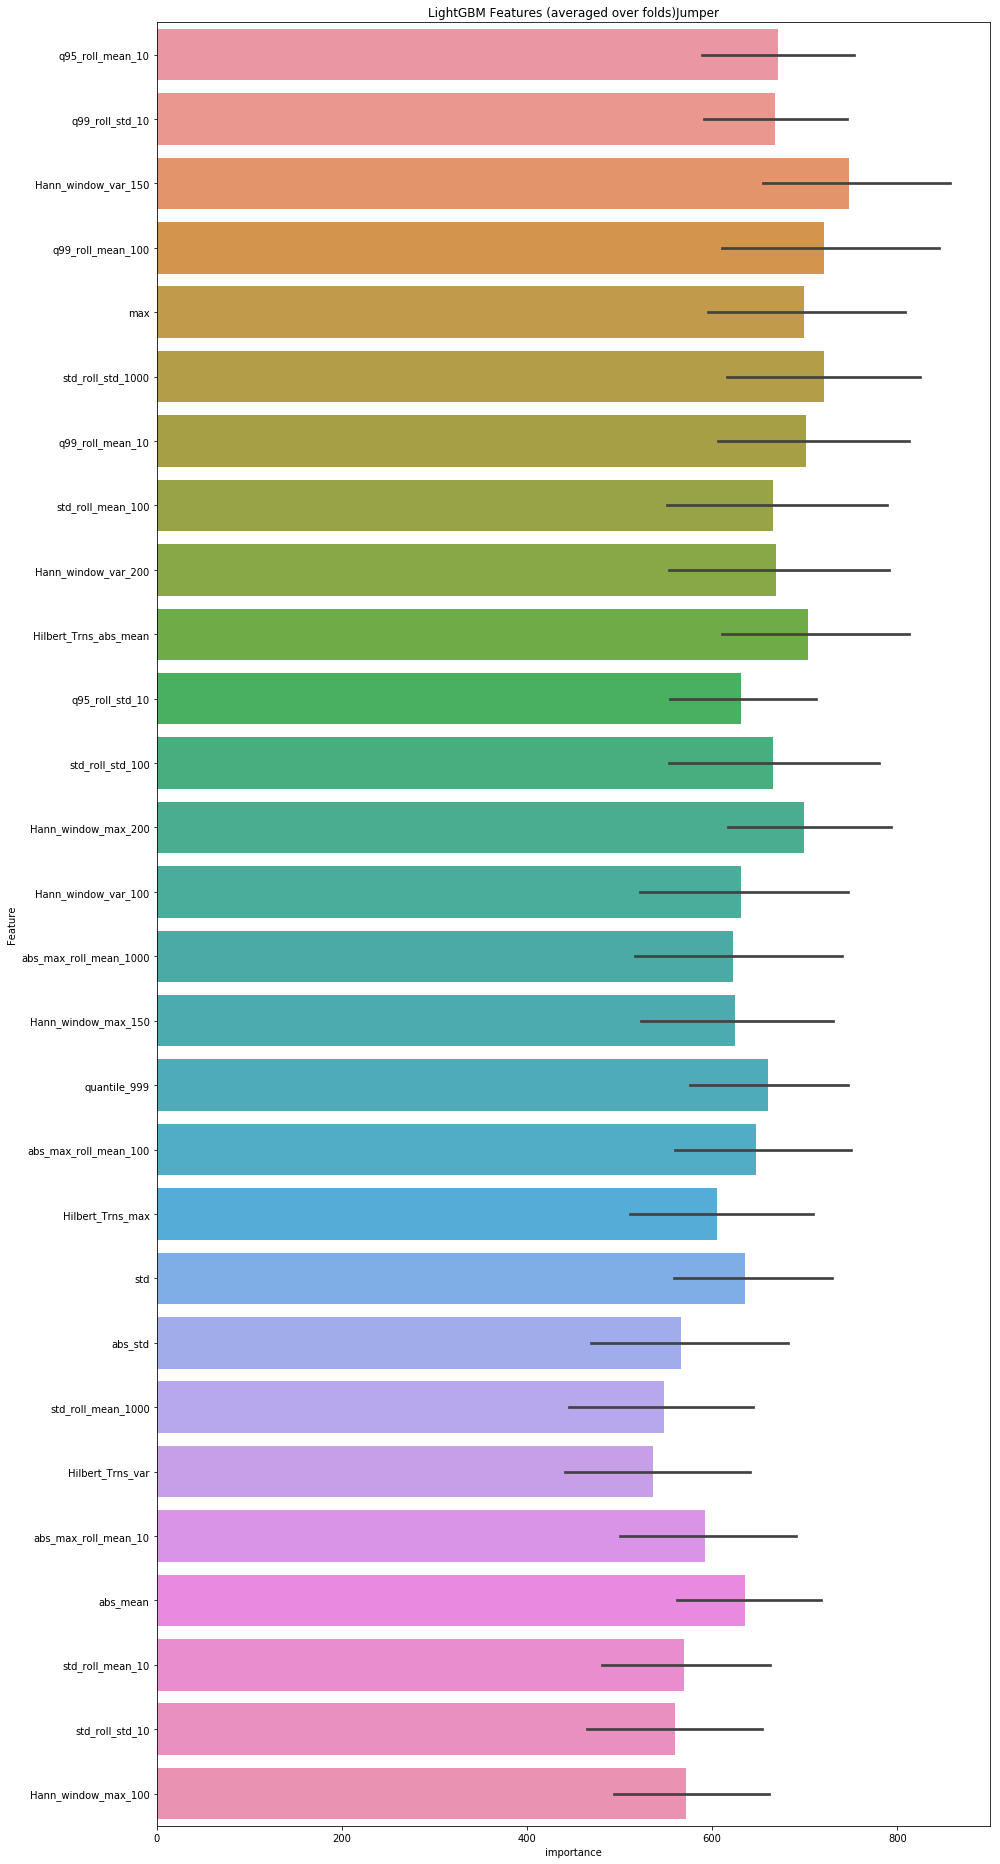

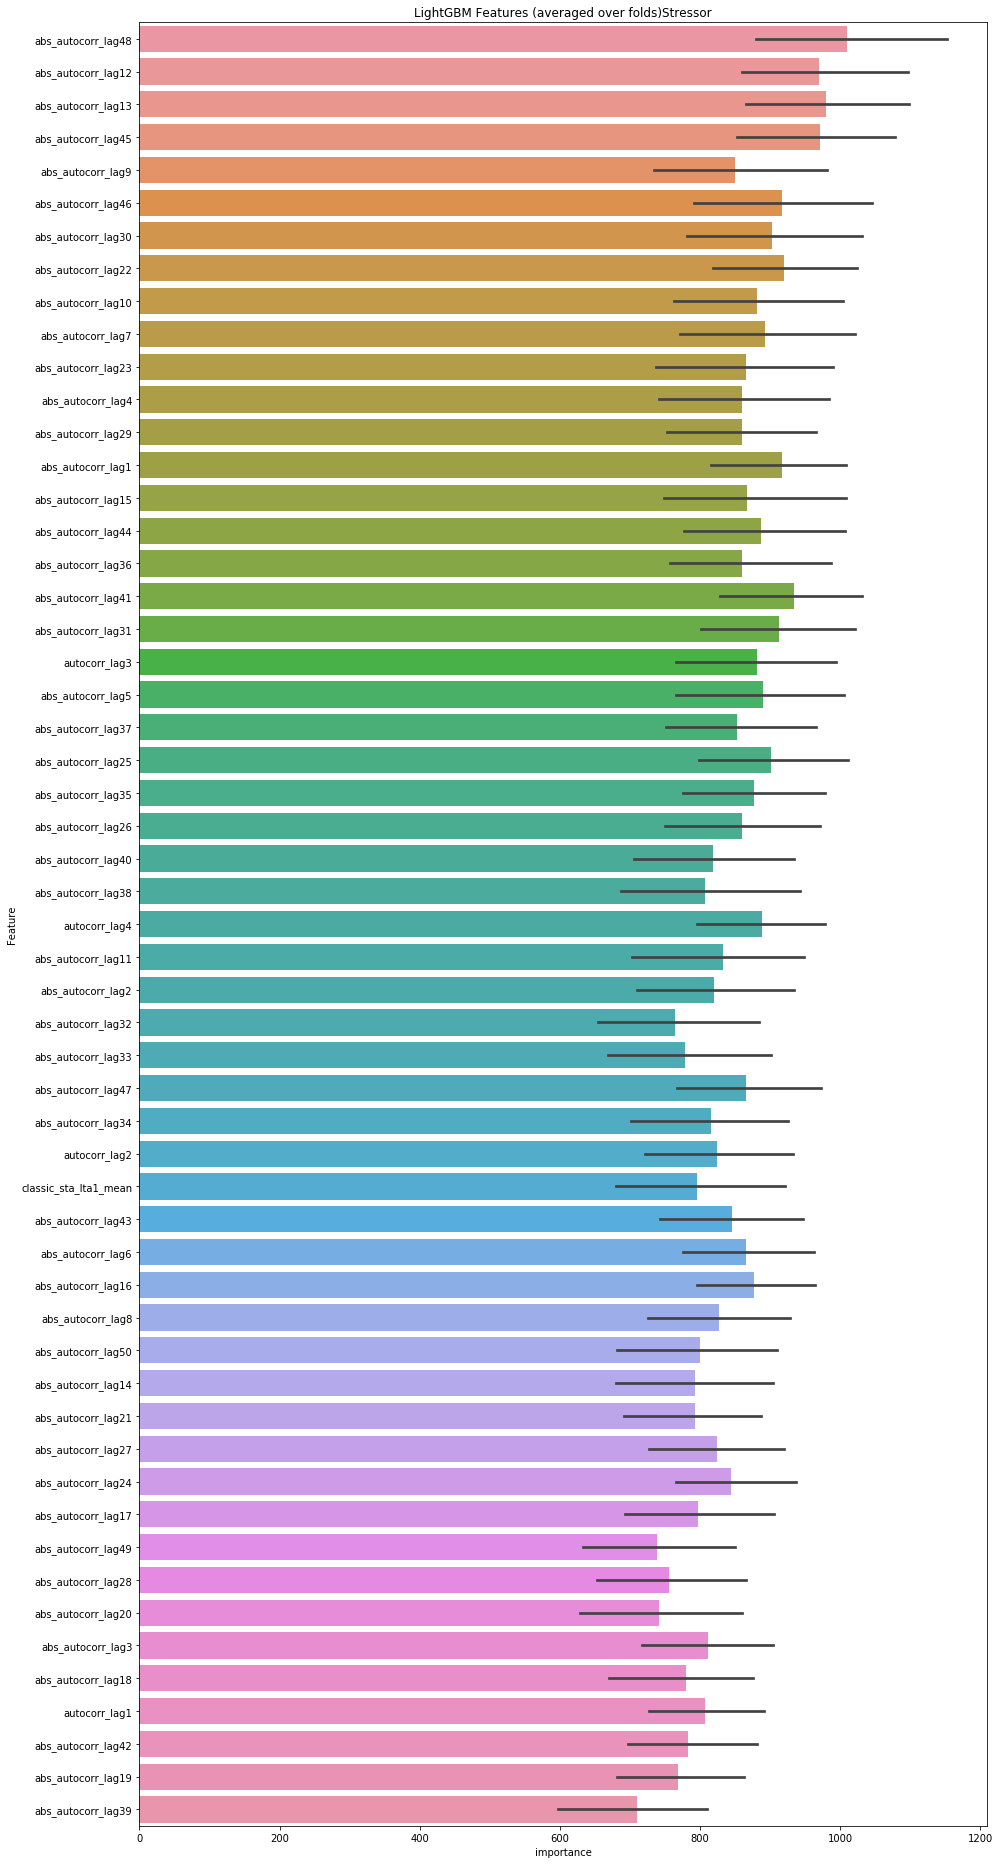

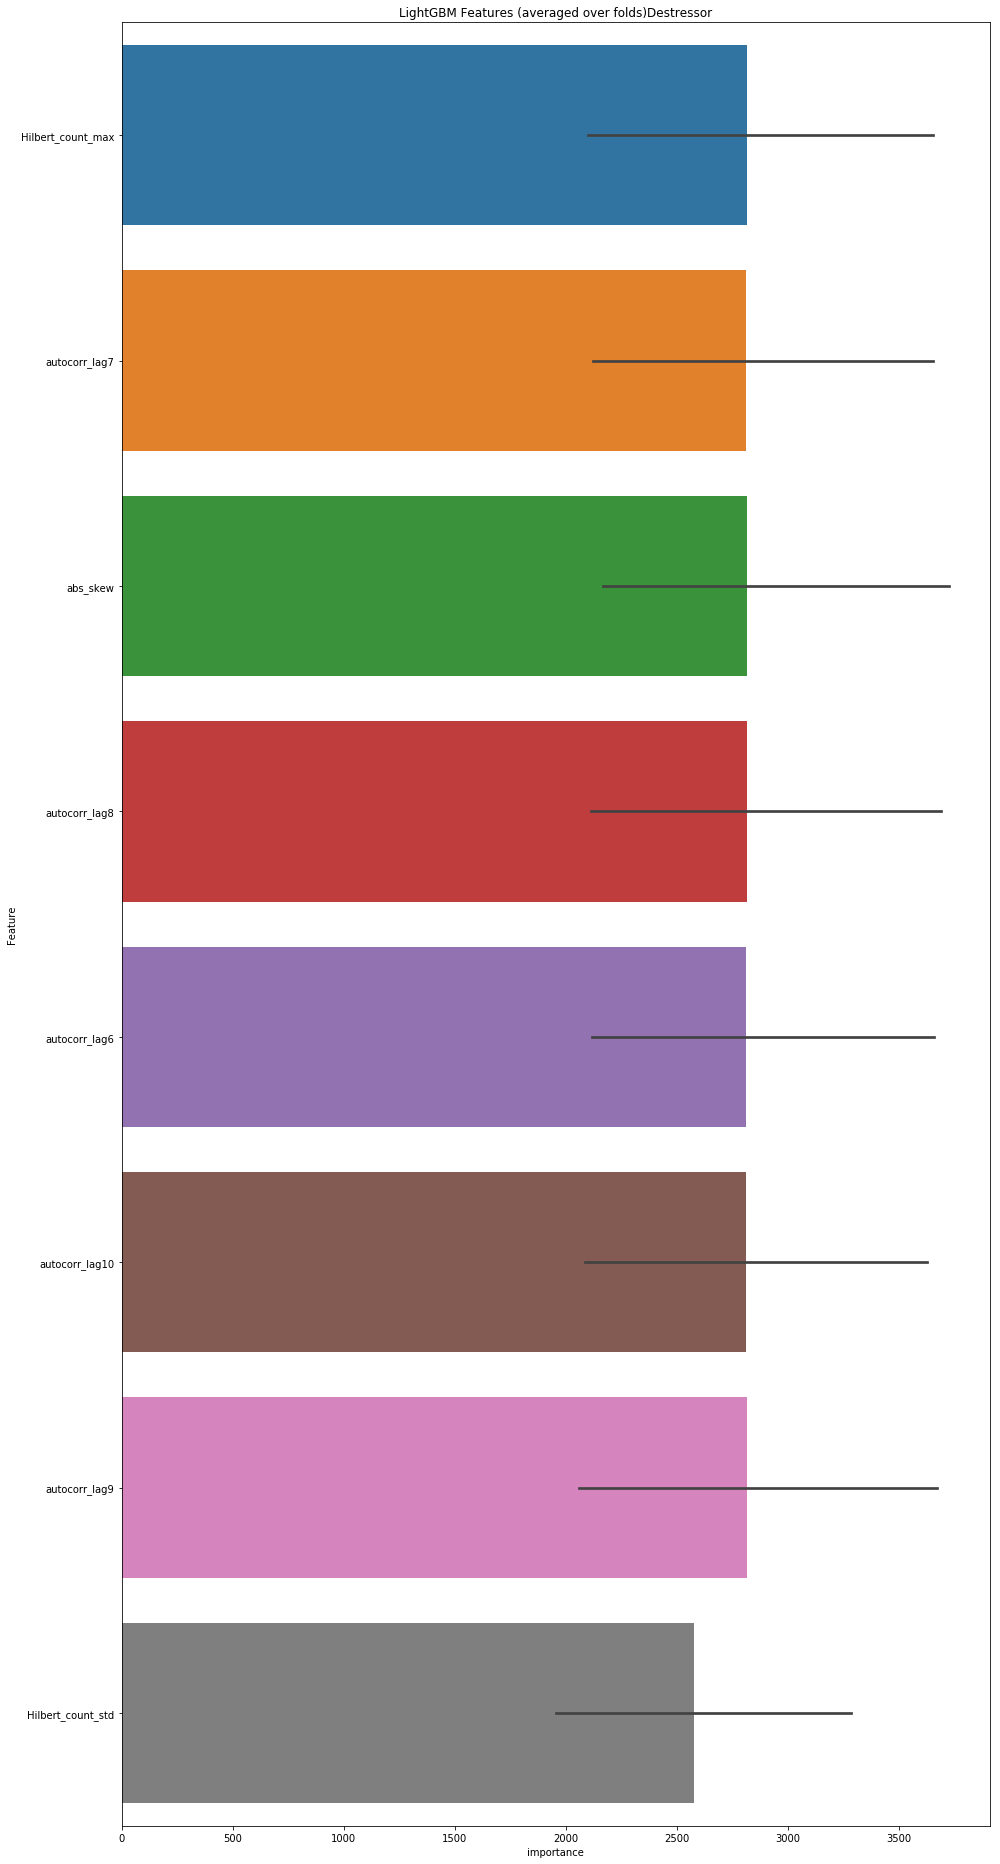

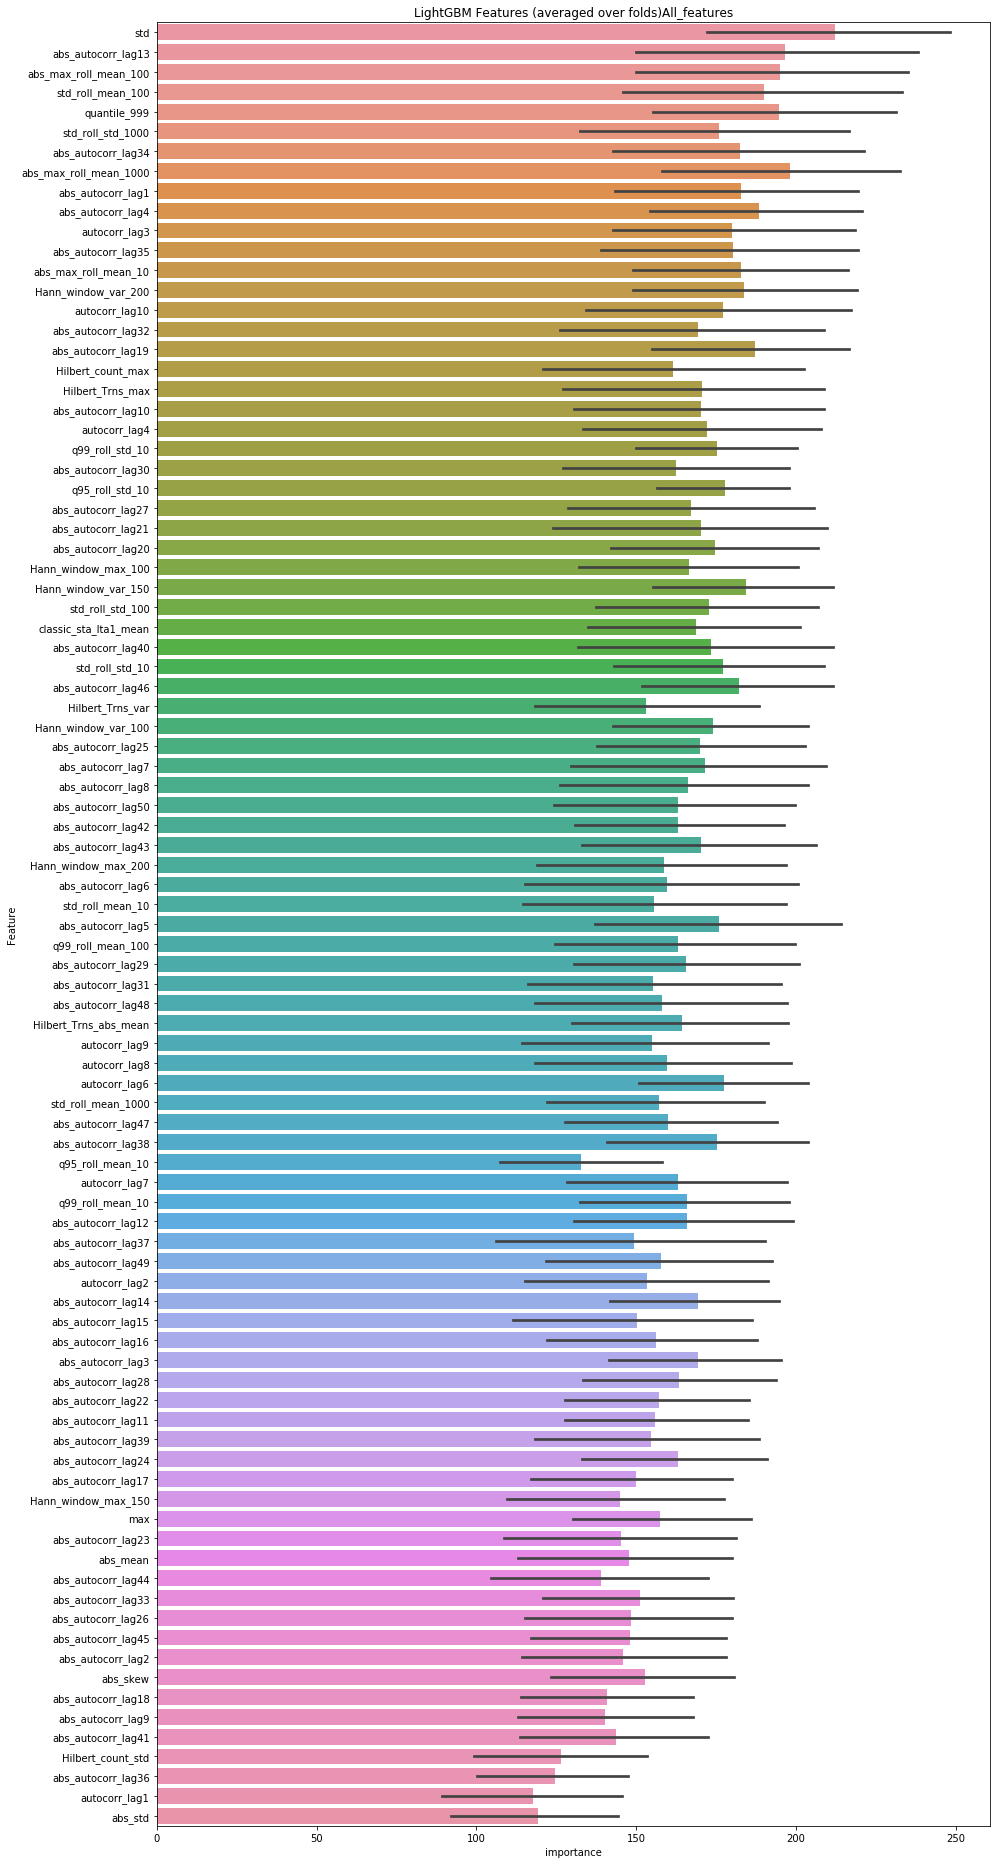

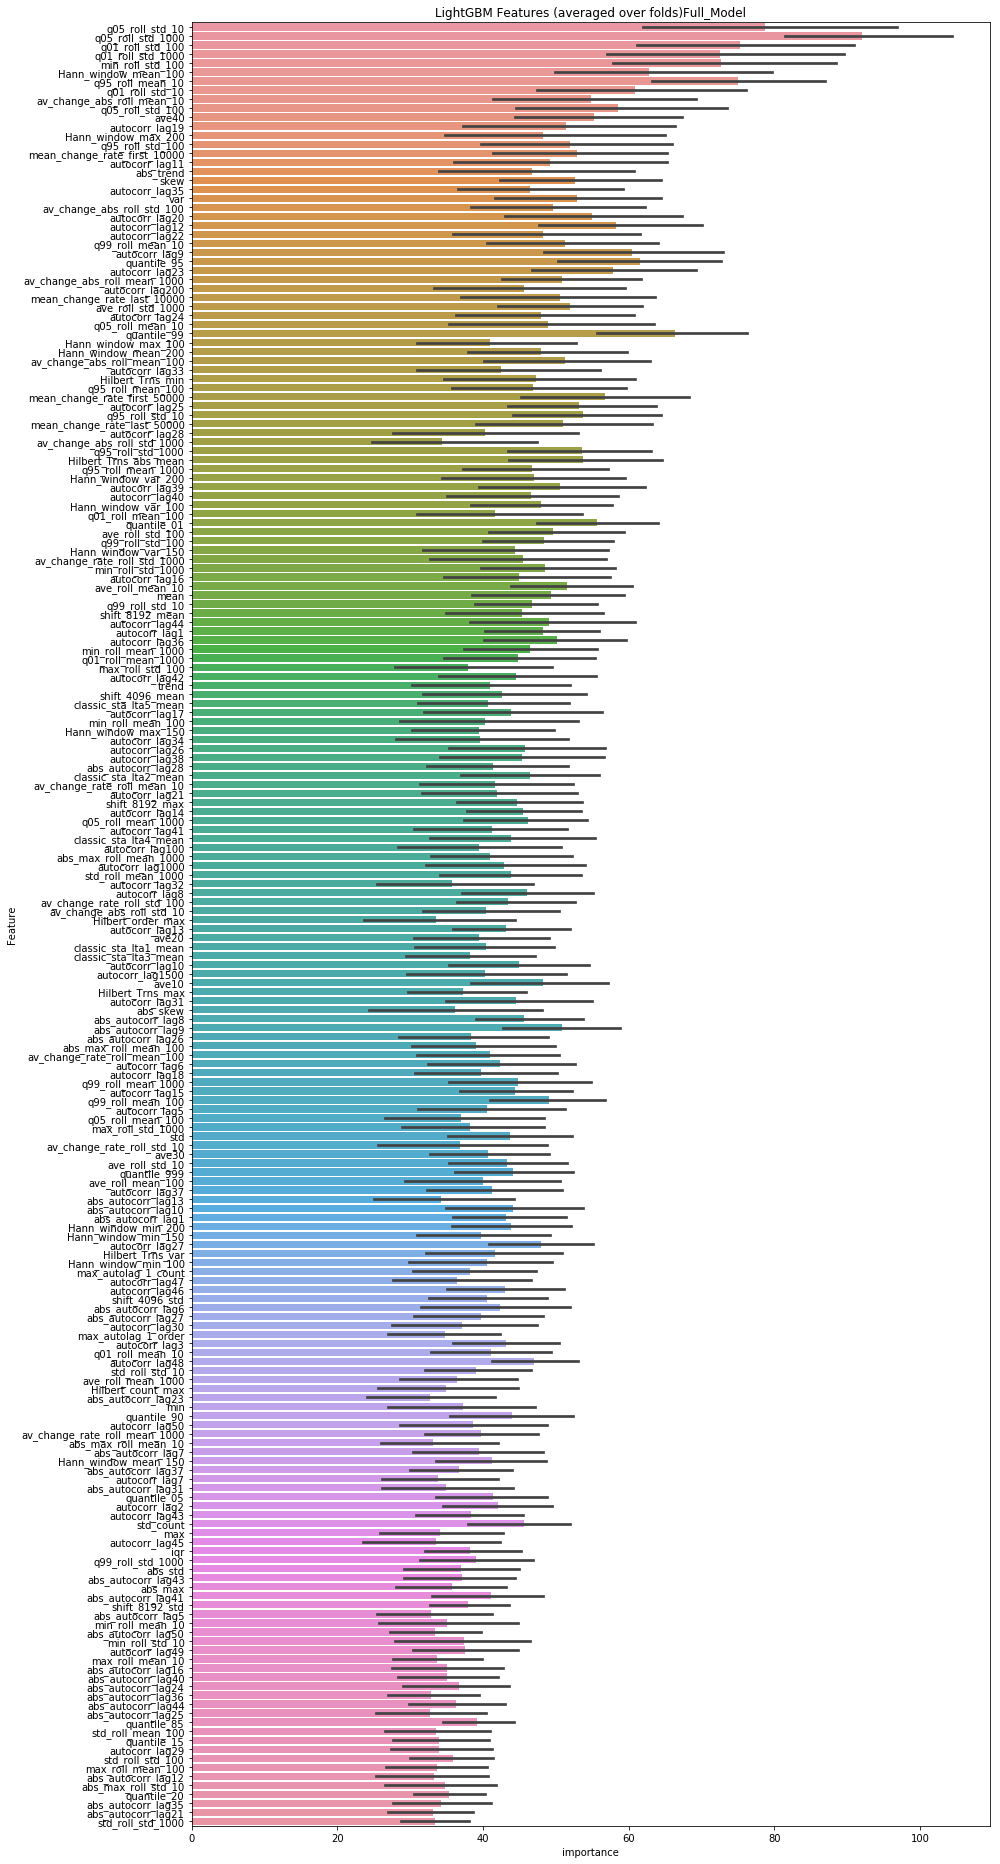

In [16]:
import seaborn as sns
importance_list = [Kien_quant_J[2],Kien_quant_S[2],Kien_quant_D[2],Kien_quant_A[2],Kien_quant_F[2]]
namelist        = ['Jumper','Stressor', 'Destressor', 'All_features','Full_Model']
for j in range(0,len(importance_list)):
    feature_importance_df = importance_list[j]
    feature_importance_df.sort_values(by = "importance", ascending = False)
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:200].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(14,26))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('LightGBM Features (averaged over folds)'+namelist[j])
    plt.tight_layout()
    plt.show()
#plt.savefig('lgbm_importances.png')

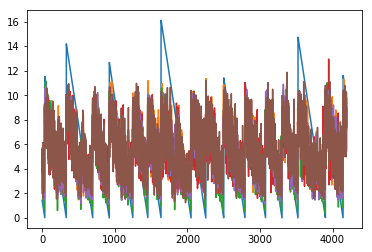

2.2005891146209873
2.3670132709964906
2.3790303516637463
2.1355681605973023
2.0477741748157667


NameError: name 'Kien_quant_J2' is not defined

In [17]:
plt.plot(y_train)
#plt.plot(np.sqrt(y_train))
plt.plot(Kien_quant_J[0])
plt.plot(Kien_quant_F[0])
plt.plot(Kien_quant_S[0])
plt.plot(Kien_quant_A[0])
plt.plot(Kien_quant_D[0])
plt.show()
print(np.mean(np.abs(y_train - (Kien_quant_J[0]))))
print(np.mean(np.abs(y_train - (Kien_quant_S[0]))))
print(np.mean(np.abs(y_train - (Kien_quant_D[0]))))
print(np.mean(np.abs(y_train - (Kien_quant_A[0]))))
print(np.mean(np.abs(y_train - (Kien_quant_F[0]))))
print(np.mean(np.abs(y_train - Kien_quant_J2[0])))

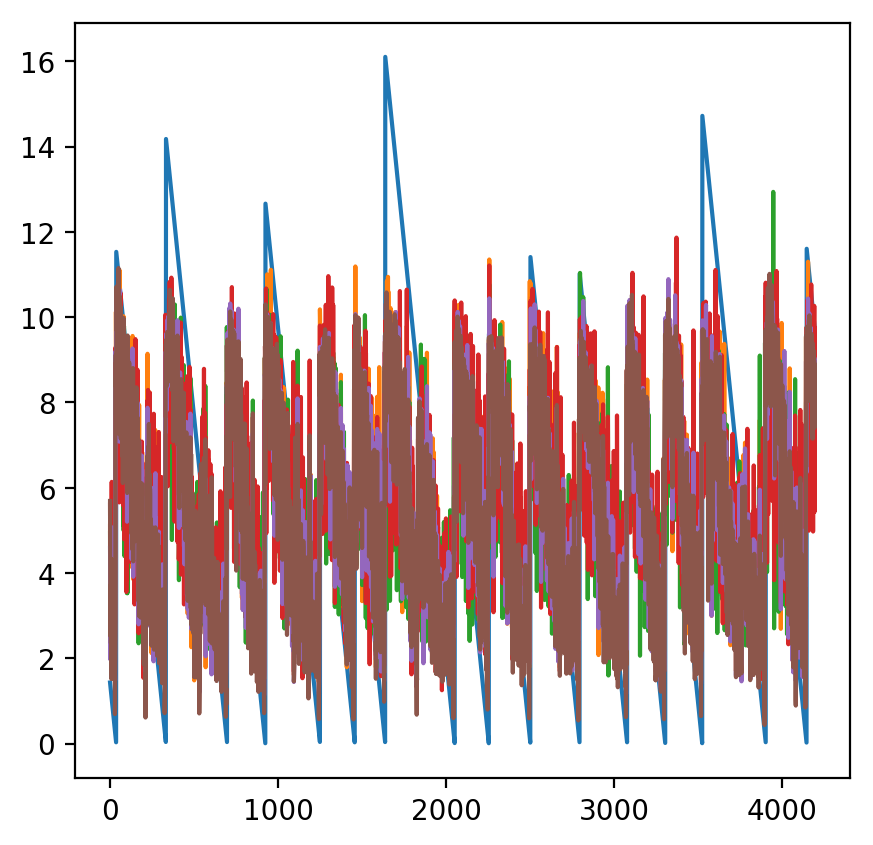

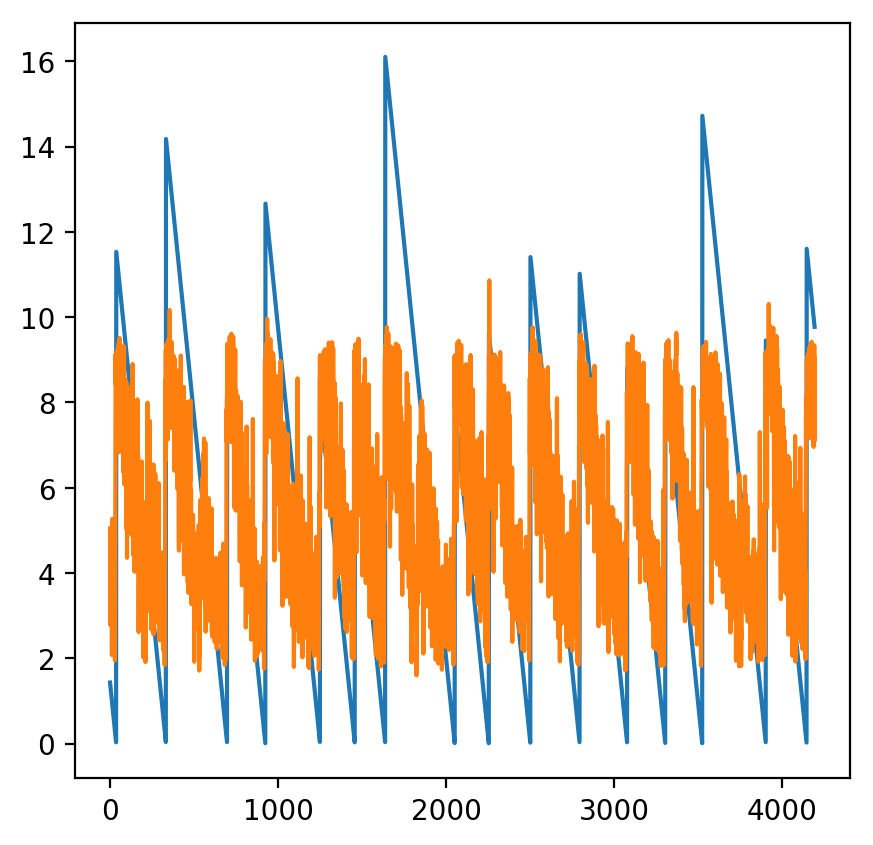

In [18]:
fig = plt.figure(figsize=(5,5),dpi=200)
plt.plot(y_train)
plt.plot(Kien_quant_J[0])
plt.plot(Kien_quant_S[0])
plt.plot(Kien_quant_D[0])
plt.plot(Kien_quant_A[0])
plt.plot(Kien_quant_F[0])

plt.show()
ave_Pred = (0.3*Kien_quant_A[0]+0.1*Kien_quant_J[0]+0.3*Kien_quant_S[0]+0.3*Kien_quant_D[0])
fig = plt.figure(figsize=(5,5),dpi=200)
plt.plot(y_train)
plt.plot(ave_Pred)


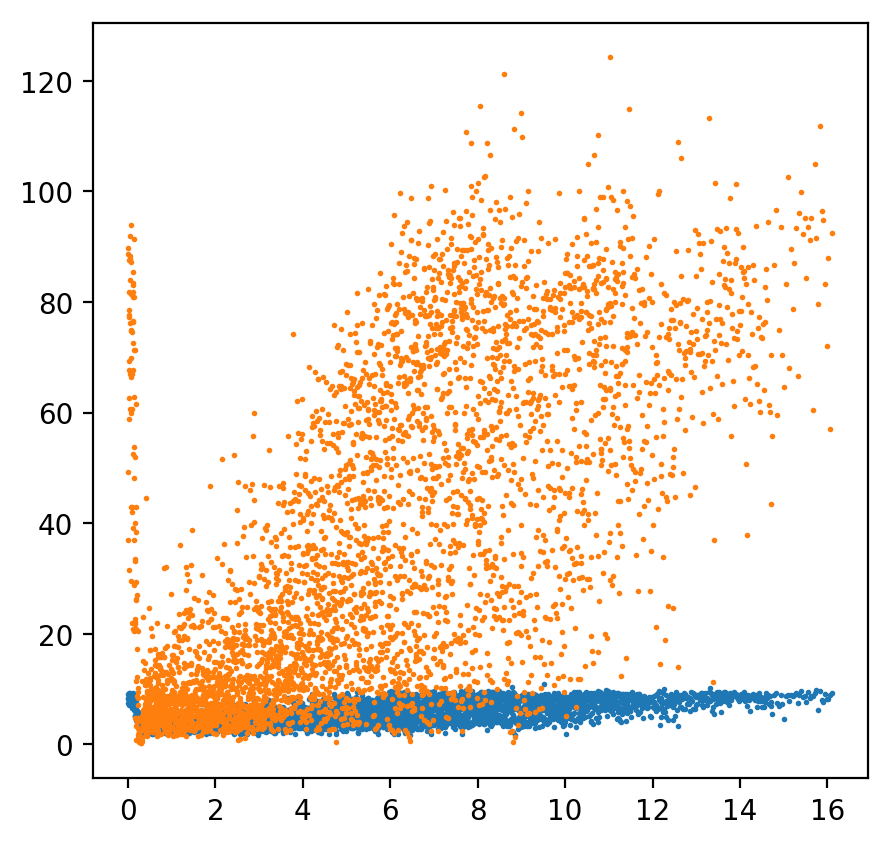

In [19]:
fig = plt.figure(figsize=(5,5),dpi=200)
plt.scatter(y_train, ave_Pred, s = 1)
plt.scatter(y_train, Kien_quant_F[0]**2, s = 1)

# submissionづくり
- ここがミソ。giba equationで調整する。
- local CVも見てみる

In [20]:
def MAE_func(x):
    return np.mean(np.abs(y_train-x))

MAE_J = MAE_func(Kien_quant_J[0]) * 6.51 / np.mean(Kien_quant_J[0])
MAE_S = MAE_func(Kien_quant_S[0]) * 6.51 / np.mean(Kien_quant_S[0])
MAE_D = MAE_func(Kien_quant_D[0]) * 6.51 / np.mean(Kien_quant_D[0])
MAE_A = MAE_func(Kien_quant_A[0]) * 6.51 / np.mean(Kien_quant_A[0])
MAE_F = MAE_func(Kien_quant_F[0]) * 6.51 / np.mean(Kien_quant_F[0])
MAE_P = MAE_func(ave_Pred)
value = [MAE_J, MAE_S, MAE_D, MAE_A, MAE_P, MAE_F]
name  = ['Jumper','Stressor','Destressor','selected_features', 'averaged_pred', 'Full_model']
for i in range(0,len(name)):
    print('MAE of {N}: {V}'.format(N=name[i],V=value[i]))


MAE of Jumper: 2.562798425748355
MAE of Stressor: 2.8107314988786123
MAE of Destressor: 2.761248786972147
MAE of selected_features: 2.5144050869266716
MAE of averaged_pred: 2.2254585295089777
MAE of Full_model: 2.424173600800142


In [21]:
submissions = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv')
submissions['time_to_failure'] = Kien_quant_A[1] * 6.51 / np.mean(Kien_quant_A[1])
submissions.to_csv('last_dance_A.csv',index = False)

submissions['time_to_failure'] = Kien_quant_J[1] * 6.51 / np.mean(Kien_quant_J[1])
submissions.to_csv('last_dance_J.csv',index = False)

submissions['time_to_failure'] = Kien_quant_D[1] * 6.51 / np.mean(Kien_quant_D[1])
submissions.to_csv('last_dance_D.csv',index = False)

submissions['time_to_failure'] = Kien_quant_S[1] * 6.51 / np.mean(Kien_quant_S[1])
submissions.to_csv('last_dance_S.csv',index = False)

submissions['time_to_failure'] = Kien_quant_F[1] * 6.51 / np.mean(Kien_quant_F[1])
submissions.to_csv('last_dance_F.csv',index = False)

In [22]:
oof_data = pd.DataFrame({'time_to_failure':y_train,
                        'Kien_Pred_Jumper':Kien_quant_J[0],
                        'Kien_Pred_Stressor':Kien_quant_S[0],
                        'Kien_Pred_Destressor':Kien_quant_D[0],
                        'Kien_Pred_selected':Kien_quant_A[0],
                        'Kien_Pred_Full':Kien_quant_F[0],
                        'Stratified':y_type})

pred_data = pd.DataFrame({#'time_to_failure':y_train,
                        'Kien_Pred_Jumper':Kien_quant_J[1],
                        'Kien_Pred_Stressor':Kien_quant_S[1],
                        'Kien_Pred_Destressor':Kien_quant_D[1],
                        'Kien_Pred_selected':Kien_quant_A[1],
                        'Kien_Pred_Full':Kien_quant_F[1]})
                        #'Stratified':y_type

oof_data.to_csv('oof_predicted_dataset.csv'  , index = False)
pred_data.to_csv('test_predicted_dataset.csv', index = False)